# Regression using Deep Neural Networks

## Load Dataset from sklearn

In [1]:
!pip install sklearn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.datasets import load_boston
boston = load_boston()

In [4]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df["TARGET"] = boston.target
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [5]:
scaler = StandardScaler()
scaler.fit(df.values[:, :-1])
df.values[:, :-1] = scaler.transform(df.values[:, :-1])

df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
501,-0.413229,-0.487722,0.115738,-0.272599,0.158124,0.439316,0.018673,-0.625796,-0.982843,-0.803212,1.176466,0.387217,-0.418147,22.4
502,-0.415249,-0.487722,0.115738,-0.272599,0.158124,-0.234548,0.288933,-0.716639,-0.982843,-0.803212,1.176466,0.441052,-0.500850,20.6
503,-0.413447,-0.487722,0.115738,-0.272599,0.158124,0.984960,0.797449,-0.773684,-0.982843,-0.803212,1.176466,0.441052,-0.983048,23.9
504,-0.407764,-0.487722,0.115738,-0.272599,0.158124,0.725672,0.736996,-0.668437,-0.982843,-0.803212,1.176466,0.403225,-0.865302,22.0
505,-0.415000,-0.487722,0.115738,-0.272599,0.158124,-0.362767,0.434732,-0.613246,-0.982843,-0.803212,1.176466,0.441052,-0.669058,11.9


## Train Model with PyTorch

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
data = torch.from_numpy(df.values).float()

data.shape

torch.Size([506, 14])

In [8]:
y = data[:, -1:]
x = data[:, :-1]

print(x.shape, y.shape)

torch.Size([506, 13]) torch.Size([506, 1])


In [9]:
n_epochs = 100000
learning_rate = 1e-4
print_interval = 5000

## Build Models

### Build Model using nn.Module

In [10]:
relu = nn.ReLU()
leaky_relu = nn.LeakyReLU(0.1)

In [11]:
class MyModel(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        super().__init__()
        
        self.linear1 = nn.Linear(input_dim, 3)
        self.linear2 = nn.Linear(3, 3)
        self.linear3 = nn.Linear(3, output_dim)
        self.act = nn.ReLU()
        
    def forward(self, x):
        # |x| = (batch_size, input_dim)
        h = self.act(self.linear1(x)) # |h| = (batch_size, 3)
        h = self.act(self.linear2(h))
        y = self.linear3(h)
        # |y| = (batch_size, output_dim)
        
        return y
    
model = MyModel(x.size(-1), y.size(-1))

model

MyModel(
  (linear1): Linear(in_features=13, out_features=3, bias=True)
  (linear2): Linear(in_features=3, out_features=3, bias=True)
  (linear3): Linear(in_features=3, out_features=1, bias=True)
  (act): ReLU()
)

### Build Model with LeakyReLU using nn.Sequential

In [12]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
)

model

Sequential(
  (0): Linear(in_features=13, out_features=3, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=3, out_features=3, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=3, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=3, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=3, out_features=1, bias=True)
)

In [13]:
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)

In [14]:
for i in range(n_epochs):
    y_hat = model(x)
    loss = F.mse_loss(y_hat, y)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    if (i + 1) % print_interval == 0:
        print('Epoch %d: loss=%.4e' % (i + 1, loss))

Epoch 5000: loss=8.4416e+01
Epoch 10000: loss=8.4415e+01
Epoch 15000: loss=8.4413e+01
Epoch 20000: loss=7.8406e+01
Epoch 25000: loss=1.3286e+01
Epoch 30000: loss=1.2725e+01
Epoch 35000: loss=1.2526e+01
Epoch 40000: loss=1.1895e+01
Epoch 45000: loss=1.1548e+01
Epoch 50000: loss=1.1223e+01
Epoch 55000: loss=1.0938e+01
Epoch 60000: loss=1.0711e+01
Epoch 65000: loss=9.3744e+00
Epoch 70000: loss=7.6595e+00
Epoch 75000: loss=6.9922e+00
Epoch 80000: loss=7.1098e+00
Epoch 85000: loss=6.8505e+00
Epoch 90000: loss=7.0606e+00
Epoch 95000: loss=6.6112e+00
Epoch 100000: loss=6.5394e+00


## Let's see the result!

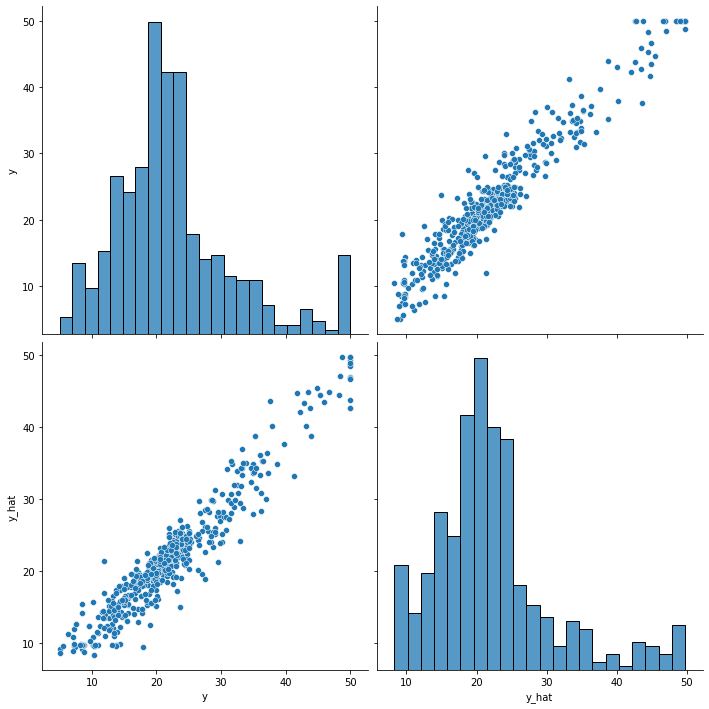

In [15]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()